今天为大家带来一篇 初步使用Keras深度学习破解验证码 的文章。
当然我们这里识别的是普通验证码，是Laravel常用的验证码库captcha

如下图，又5个数字字母所组成的验证码。我用PHP一共生成了5万个验证码。后面也会提供给大家

#### 导入所需的库

这里我们还是使用Keras，底层使用Tensorflow做为底层库。

本次使用的模型是简单的卷积神经网络模型，后面也会使用更加复杂的模型

卷积神经网络（Convolutional Neural Network,CNN）是一种前馈神经网络，它的人工神经元可以响应一部分覆盖范围内的周围单元，对于大型图像处理有出色表现。它包括卷积层(alternating convolutional layer)和池层(pooling layer)。

一般地，CNN的基本结构包括两层，其一为特征提取层，每个神经元的输入与前一层的局部接受域相连，并提取该局部的特征。一旦该局部特征被提取后，它与其它特征间的位置关系也随之确定下来；其二是特征映射层，网络的每个计算层由多个特征映射组成，每个特征映射是一个平面，平面上所有神经元的权值相等。特征映射结构采用影响函数核小的sigmoid函数作为卷积网络的激活函数，使得特征映射具有位移不变性。此外，由于一个映射面上的神经元共享权值，因而减少了网络自由参数的个数。卷积神经网络中的每一个卷积层都紧跟着一个用来求局部平均与二次提取的计算层，这种特有的两次特征提取结构减小了特征分辨率。

In [18]:
import numpy as np
import os
import pickle

from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input, concatenate
from keras.layers.convolutional import Conv2D, Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta
from matplotlib import pyplot as plt 

### 配置参数

In [5]:
#验证码所包含的字符 _表示未知
captcha_word = "_2346789abcdefghjmnpqrtuxyzABCDEFGHJMNPQRTUXYZ"

#图片的长度和宽度
width = 120
height = 36

#每个验证码所包含的字符数
word_len = 5
#字符总数
word_class = len(captcha_word)

#验证码素材目录
train_dir = 'train'

#生成字符索引，同时反向操作一次，方面还原
char_indices = dict((c, i) for i,c in enumerate(captcha_word))
indices_char = dict((i, c) for i,c in enumerate(captcha_word))

#验证码字符串转数组
def captcha_to_vec(captcha):    
    #创建一个长度为 字符个数 * 字符种数 长度的数组
    vector = np.zeros(word_len * word_class)
    
    #文字转成成数组
    for i,ch in enumerate(captcha):
        idex = i * word_class + char_indices[ch]
        vector[idex] = 1
    return vector

#把数组转换回文字
def vec_to_captcha(vec):
    text = []
    #把概率小于0.5的改为0，标记为错误
    vec[vec < 0.5] = 0
        
    char_pos = vec.nonzero()[0]
    
    for i, ch in enumerate(char_pos):
        text.append(captcha_word[ch % word_class])
    return ''.join(text)

test_vec = captcha_to_vec("2ngF4")
vec_test = vec_to_captcha(test_vec)

print(test_vec)
print(vec_test)


[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2ngF4


### 加载数据

训练模型的时候，我们可以选择两种方式来生成我们的训练数据，一种是直接全部载入内存，然后开始训练，一种是定义一个数据生成器，然后利用 fit_generator 分批加载数据来训练。

因为样本是5万张，但是只有200多M，可以一次性载入内存。

最后会生成pickle文件。python的pickle模块实现了基本的数据序列和反序列化。通过pickle模块的序列化操作我们能够将程序中运行的对象信息保存到文件中去，永久存储；通过pickle模块的反序列化操作，我们能够从文件中创建上一次程序保存的对象。

如果使用我保存好的pickle文件，可以不用执行下列步骤

In [6]:
#获取目录下样本列表
image_list = []

#
for item in os.listdir(train_dir):
    image_list.append(item)
np.random.shuffle(image_list)


In [8]:
#创建数组，储存图片信息。结构为(50321, 36, 120, 3)，50321代表样本个数，然后是宽度和高度。
# 3代表图片的通道数，如果对图片进行了灰度处理，可以改为单通道 1
X = np.zeros((len(image_list), height, width, 3), dtype = np.uint8)
# 创建数组，储存标签信息
y = np.zeros((len(image_list), word_len * word_class), dtype = np.uint8)

for i,img in enumerate(image_list):
    if i % 10000 == 0:
        print(i)
    img_path = train_dir + "/" + img
    #读取图片
    raw_img = image.load_img(img_path, target_size=(height, width))
    #讲图片转为np数组
    X[i] = image.img_to_array(raw_img)
    #讲标签转换为数组进行保存
    y[i] = captcha_to_vec(img.split('.')[0])

0
10000
20000
30000
40000
50000


In [10]:
#保存成pkl文件
file = open('captcha_train_data.pkl','wb')
pickle.dump((X,y) , file)

### 加载数据，读取pickle文件

In [11]:
#读取pickle文件
file = open('captcha_train_data.pkl', 'rb')
X, y = pickle.load(file)

### 创建模型

In [13]:
#创建输入，结构为 高，宽，通道
input_tensor = Input( shape=(height, width, 3))

x = input_tensor

#构建卷积网络
#两层卷积层，一层池化层，重复3次。因为生成的验证码比较小，padding使用same
x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)


x = Convolution2D(64, 3, padding='same', activation='relu')(x)
x = Convolution2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Convolution2D(128, 3, padding='same', activation='relu')(x)
x = Convolution2D(128, 3, padding='same',activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

#Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。
x = Flatten()(x)
#为输入数据施加Dropout。Dropout将在训练过程中每次更新参数时随机断开一定百分比（rate）的输入神经元，Dropout层用于防止过拟合。
x = Dropout(0.25)(x)

#Dense就是常用的全连接层
#最后连接5个分类器，每个分类器是46个神经元，分别输出46个字符的概率。
x = [Dense(word_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(word_len)]
output = concatenate(x)


In [15]:
#构建模型
model = Model(inputs=input_tensor, outputs=output)

#因为训练可能需要数个小时，所以这里加载了之前我训练好的参数。准确率为94%
#可以直接使用此参数继续进行训练，也可以自己从头开始训练
model.load_weights('captcha_weights.0.9430.hdf5')

#这里优化器选用Adadelta，学习率0.1
opt = Adadelta(lr=0.1)
#编译模型以供训练，损失函数使用 categorical_crossentropy，使用accuracy评估模型在训练和测试时的性能的指标
model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


### 开始训练模型

In [16]:
#每次epoch都保存一下权重，用于继续训练
checkpointer = ModelCheckpoint(filepath="output/weights.{epoch:02d}--{val_loss:.2f}-{val_acc:.4f}.hdf5", 
                               verbose=2, save_weights_only=True)
#开始训练，validation_split代表10%的数据不参与训练，用于做验证急
#我之前训练了50个epochs以上，这里根据自己的情况进行选择。如果输出的val_acc已经达到你满意的数值，可以终止训练
model.fit(X, y, epochs= 1,callbacks=[checkpointer], validation_split=0.1)

Train on 45288 samples, validate on 5033 samples
Epoch 1/1
45288/45288 [==============================] - 2034s - loss: 8.1810 - acc: 0.9464 - val_loss: 8.1724 - val_acc: 0.9426


In [17]:
#保存权重和模型
model.save_weights('output/captcha_model_weights.h5')
model.save('output/captcha__model.h5')

### 训练完成，进行验证

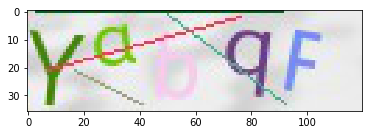

原始： YabqF 预测 YabqF


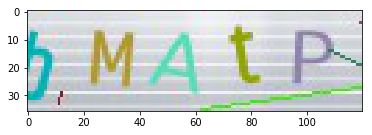

原始： bMAtP 预测 bMAtP


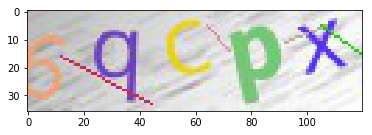

原始： 6qCpx 预测 6qCpx


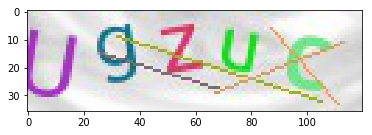

原始： UgzuC 预测 UgzuC


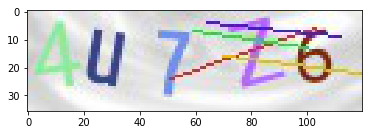

原始： 4u7Z6 预测 4u7Z6


In [21]:
#测试验证方法
def testCaptcha(index):
    raw_img = X[index]
    true_label = y[index]
    
    X_test = np.zeros((1, height, width, 3), dtype = np.float32)
    X_test[0] = image.img_to_array(raw_img)
    
    result = model.predict(X_test)
    
    vex_test = vec_to_captcha(result[0])
    true_test = vec_to_captcha(true_label)
    
    plt.imshow(raw_img)
    plt.show()
    
    print("原始：",true_test,"预测", vex_test)
    
#选5张验证码进行验证
for i in range(5):
    testCaptcha(i)

### 改进
对于这种按顺序的文字验证码，还有一种更好方法可以使用，那就是循环神经网络来识别序列。
我会在后面继续介绍如何用循环神经网络构建模型。